In [24]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "data/"
  ensure_dir(save_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


In [35]:
import numpy as npo
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import jax.numpy as np
from jax import random
import jax.random
from jax.api import jit
import os

!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

# t_start = datetime.now(pytz.timezone('US/Eastern'))
# t_end = datetime.now(pytz.timezone('US/Eastern'))
# print('Time Elapsed: ' + time_diff(t_start,t_end))

# Dataset Preperation

(60000, 28, 28)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


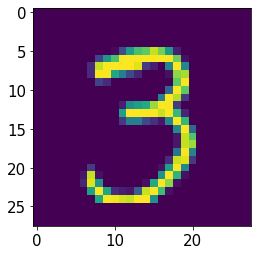

In [27]:
# class to download and maintain datasets
class DataSet():
  def __init__(self, name, subset_size, batch_size, test_size, key):
    self.name = name
    self.subset_size = subset_size 
    self.num_classes = 10
    if name == 'CIFAR10':
      self.total_size = 50000
      self.dim = 1024
    elif name == 'CIFAR100':
      self.total_size = 50000
      self.dim = 1024
      self.num_classes = 100
    elif name == 'MNIST':
      self.total_size = 60000
      self.dim = 784
    else:
      raise Exception('No valid dataset is chosen') 

    self.batch_size = batch_size
    self.key = key
    self.subset_inds = random.shuffle(key, np.arange(self.total_size))[0:subset_size]
    self.test_size = test_size
    self.all_data = npo.zeros((self.total_size, self.dim))
    self.all_labels = npo.zeros((self.total_size, self.num_classes))
    self.all_test_data = npo.zeros((self.test_size, self.dim))
    self.all_test_labels = npo.zeros((self.test_size, self.num_classes))
    return

  # processes data into np arrays
  def process_data(self, batch_block):
    image, label = batch_block['image'], batch_block['label']
    samples = image.shape[0]
    if image.shape[3] == 3:
      image = tf.image.rgb_to_grayscale(tf.image.per_image_standardization(image)).numpy()
    
    ## Normalize the images to zero mean and unit norm
    image = np.reshape(image, (image.shape[0], self.dim))
    image = image.T - np.mean(image, axis = 1)
    image = image / np.linalg.norm(image, axis = 0)

    label = np.eye(self.num_classes)[label]
    return {'image': image.T, 'label': label} 

  def download_and_process(self):
    batch_size = self.batch_size
    if self.name =='CIFAR10':
      test_data = tfds.load('cifar10', split=tfds.Split.TEST)
      train_data = tfds.load('cifar10', split=tfds.Split.TRAIN)
    elif self.name == 'CIFAR100':
      test_data = tfds.load('cifar100', split=tfds.Split.TEST)
      train_data = tfds.load('cifar100', split=tfds.Split.TRAIN)
    else:
      test_data = tfds.load('mnist', split=tfds.Split.TEST)
      train_data = tfds.load('mnist', split=tfds.Split.TRAIN)
    train_data_shuff = tfds.as_numpy(train_data.shuffle(1024).batch(batch_size))
    test_data_shuff = tfds.as_numpy(test_data.shuffle(1024).batch(batch_size)) 

    for i,batch in enumerate(train_data_shuff):
      datai = self.process_data(batch)
      self.all_data[i*batch_size:(i+1)*batch_size,:] = datai['image']
      self.all_labels[i*batch_size:(i+1)*batch_size,:] = datai['label']
    
    for i,batch in enumerate(test_data_shuff):
      datai = self.process_data(batch)
      self.all_test_data[i*batch_size:(i+1)*batch_size,:] = datai['image']
      self.all_test_labels[i*batch_size:(i+1)*batch_size,:] = datai['label']
    
    return
  
  # gets a subset of the data to train/test on
  def get_subset(self):
    train_sub = self.all_data[self.subset_inds,:]
    labels_sub = self.all_labels[self.subset_inds,:]
    return (train_sub, labels_sub)


def test_dataset_class(dataset_name, img_num):

  key = random.PRNGKey(0)
  test_size = 10000
  subset_size = 500
  batch_size = 500
  d_mnist = DataSet(dataset_name, subset_size, batch_size, test_size, key)
  d_mnist.download_and_process()

  x = d_mnist.all_data.reshape(60000,28,28)
  y = d_mnist.all_labels

  print(x.shape)
  print(y[img_num])
  plt.imshow(x[img_num]);

test_dataset_class('MNIST', 50)

# Theory Curves

In [28]:
## Gaussian kernel function
def gaussian_kernel(X, Xp, ker_var):
    G1 = np.dot(X, X.T)
    G2 = np.dot(Xp, Xp.T)
    G3 = np.dot(X, Xp.T)
    R = np.outer(np.diag(G1), np.ones(Xp.shape[0])) + np.outer(np.ones(X.shape[0]), np.diag(G2)) - 2*G3
    K = np.exp(-0.5*R / ker_var**2)
    
    return K

class Theory_Gaussian():

  def __init__(self, expt):
    self.expt = expt
    self.ker_var = expt.ker_var
    self.lamb = expt.lamb
    self.results = []
    return
  
  ## Perform eigendecomposition of kernel Gram matrix
  def get_spectrum_vecs(self, subset_size):

    ker_var = self.ker_var
    X = self.expt.dataset.all_data[self.expt.dataset.subset_inds,:]
    y = self.expt.dataset.all_labels[self.expt.dataset.subset_inds,:]
    num_pca = len(self.expt.dataset.subset_inds)
    assert(subset_size == num_pca)

    results = []
    spectra = []
    target_spectra = []
    for i, var in enumerate(ker_var):
      K = gaussian_kernel(X, X, var)

      spectrum, vecs = np.linalg.eigh(K)
      inds = np.argsort(spectrum)[::-1]
      spectrum = np.abs(spectrum[inds] * (spectrum[inds] > 0)) / subset_size

      vecs = vecs[:,inds]
      coeffs = np.dot(vecs.T, y)
      result = {'spectrum': spectrum, 'vecs': vecs, 'coeffs': coeffs}
      results += [result]
    self.results = results
    return results 
  
  def theory_learning_curves(self, pvals):

    all_errs = npo.zeros((len(self.ker_var), len(self.lamb), len(self.expt.noise_std), len(pvals)))
    train_errs = npo.zeros((len(self.ker_var), len(self.lamb), len(self.expt.noise_std), len(pvals)))

    ker_var = self.ker_var
    lamb = self.lamb
    noise_std = self.expt.noise_std
    num_pca = len(self.expt.dataset.subset_inds)

    for i, var in enumerate(ker_var):
      r = self.results[i]
      spectrum = r['spectrum']
      coeffs = r['coeffs']
      w = coeffs

      pvals = pvals # np.log10(1-pvals/num_pca)/np.log10(1-1/num_pca)

      for j, reg in enumerate(lamb):
        print("ker_var: %0.2f | lamb = %.2e | spectral max: %.5f  | min: %.5f" % (var, reg, npo.amax(spectrum), npo.amin(spectrum)))
        ## Solve implicit equation
        kappa_vals = ker_sim.solve_kappa(pvals, reg, spectrum)
        gamma_vals= np.array([ker_sim.gamma_fn(pvals[i], kappa_vals[i], spectrum).sum() for i in range(len(pvals))])
        
        ## Calculate generalization error
        noiseless = npo.zeros(len(pvals))
        weight_sum = np.sum(w**2, axis = 1)
        prefactor = kappa_vals**2/(1 - gamma_vals)/num_pca
        for l, p in enumerate(pvals):
          noiseless[l] = prefactor[l] * np.sum(weight_sum/(p*spectrum + kappa_vals[l])**2)

        for k, noise in enumerate(noise_std):
          noise_error = noise**2*coeffs.shape[1] * gamma_vals/(1 - gamma_vals) 
          gen_err = noiseless + noise_error
          all_errs[i,j,k] = gen_err
          train_errs[i,j,k] = reg**2/kappa_vals**2 * (gen_err + noise**2)

    return all_errs, train_errs

# Experiment Functions

In [29]:
####### Gaussian Generalization ############
## Gaussian kernel (note the relative factor of 1/dimension)
## This is the original form of the kernel in the paper
## However, in calculating theoretical curves using KPCA, 
## we cannot calculate the degeneracy associated to each 
## eigenvector. Hence we remove this factor and the corresponding
## eigenvalues above becomes the scaled eigenvalues \bar \eta_K.
## See SI.4.1 - Gaussian Kernel

def gaussian_kernel(X, Xp, ker_var):
    G1 = np.dot(X, X.T)
    G2 = np.dot(Xp, Xp.T)
    G3 = np.dot(X, Xp.T)
    R = np.outer(np.diag(G1), np.ones(Xp.shape[0])) + np.outer(np.ones(X.shape[0]), np.diag(G2)) - 2*G3
    K = np.exp(-0.5*R / ker_var**2 / X.shape[1])
    
    return K

def gaussian_regression(key, X, y, noise_std, pvals, ker_var, lamb, num_avg):
    keys = random.split(key, num_avg)
    errs = npo.zeros(len(pvals))
    errs_onehot = npo.zeros(len(pvals))
    stds = npo.zeros(len(pvals))

    gaussian_kernel_jit = jit(gaussian_kernel)

    for i, p in enumerate(pvals):
        print('p: ' + str(p), end = '\r')
        errs_i = npo.zeros(num_avg)
        errs_onehot_i = npo.zeros(num_avg)
        for j in range(num_avg):
            shuff_inds = random.shuffle(keys[j,:], np.arange(len(y)))
            inds = shuff_inds[0:p]
            inds_test = shuff_inds[0:len(y)]

            # Specify the training samples with noisy labels
            Xtrain = X[inds,:]
            ytrain = y[inds,:] + npo.random.normal(0, noise_std, y[inds,:].shape)

            # Specify the test samples
            Xtest = X[inds_test,:]
            ytest = y[inds_test,:]

            ## Performing regression
            K = gaussian_kernel_jit(Xtrain, Xtrain, ker_var)
            Ktest_hat = gaussian_kernel_jit(Xtest, Xtrain, ker_var)
            
            alpha = np.dot(np.linalg.inv(K + lamb*np.eye(p)), ytrain)
            yhat = np.dot(Ktest_hat, alpha)
            
            errs_i[j] = np.linalg.norm(yhat -  ytest)**2 / ytest.shape[0]
            errs_onehot_i[j] = np.linalg.norm(yhat -  onehot(ytest))**2 / ytest.shape[0]
            
        errs[i] = np.mean(errs_i)
        errs_onehot[i] = np.mean(errs_onehot_i)
        stds[i] = np.std(errs_i)
        
    return errs, stds, errs_onehot


def onehot(a):
  idx = npo.argmax(a,axis=1)
  b = npo.zeros(a.shape)
  for i in range(idx.shape[0]):
    b[i,idx[i]] = 1
  return b

class Experiment():
  def __init__(self, dataset, num_repeats, pvals, noise_std, ker_var, lamb):
    self.dataset = dataset
    self.key = dataset.key
    self.num_repeats = num_repeats
    self.pvals = pvals
    self.noise_std = noise_std
    self.ker_var = ker_var
    self.lamb = lamb
    return

  def Gaussian_train(self):

    ker_var = self.ker_var
    lamb = self.lamb
    noise_std = self.noise_std
    num_avg = self.num_repeats
    
    all_errs = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_errs_onehot = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_stds = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))

    tot_time_start = datetime.now()
    for i, var in enumerate(ker_var):
      for j, reg in enumerate(lamb):
        for k, noise in enumerate(noise_std):
          print('******** ker_var: %0.2e, lamb: %0.2e, noise: %0.2e ************' % (var, reg, noise))
          errs, stds, errs_onehot = gaussian_regression(self.key, *self.dataset.get_subset(), noise, self.pvals, var, reg, num_avg)
          all_errs[i,j,k] = errs
          all_errs_onehot[i,j,k] = errs_onehot
          all_stds[i,j,k] = stds

    tot_time_end = datetime.now()
    print('Total Time for Gaussian Regression with P = %d: ' % np.amax(self.pvals) + time_diff(tot_time_start, tot_time_end))

    return all_errs, all_stds, all_errs_onehot

# Perform Experiments

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

time_exp_start = datetime.now(pytz.timezone('US/Eastern'))
timestamp = time_exp_start.strftime("%m-%d_%H-%M")
print('Experiment Start Time: ', timestamp)

dataset_name ='CIFAR10'
expt_decorator = str(dataset_name + '_vary_reg_noise')

key = random.PRNGKey(0)
test_size = 10000
subset_size = 10000
batch_size = 1000
d_mnist = DataSet(dataset_name, subset_size, batch_size, test_size, key)
d_mnist.download_and_process()

num_repeats = 10
pvals = npo.logspace(np.log10(10), np.log10(subset_size), 15).astype('int')

ker_var = [0.1,0.5]
lamb = [0.01, 0.08, 0.5]
noise_std = np.sqrt(np.array([0, 0.5, 1.5]))

params = {'dataset_name': dataset_name,
 'test_size': test_size,
 'subset_size': subset_size,
 'batch_size': batch_size,
 'num_repeats': num_repeats,
 'noise_std': noise_std,
 'ker_var': ker_var,
 'lamb': lamb}

## Regression Learning Curves ###
gauss_expt = Experiment(d_mnist, num_repeats, pvals, noise_std, ker_var, lamb)
errs_ker, stds_ker, errs_onehot_ker = gauss_expt.Gaussian_train()

if save_data:
  filename_RBF = timestamp + expt_decorator + '_Gauss_experiment_final.npz'
  np.savez(filename_RBF, pvals, errs_ker, stds_ker)

## Theory Learning Curves ###
ptheory = np.logspace(np.log10(10), np.log10(subset_size)-0.1, 100)
t = Theory_Gaussian(gauss_expt)
results = t.get_spectrum_vecs(subset_size) # Get the spectrum
all_errs, train_errs = t.theory_learning_curves(ptheory) # Get the theory learning curves

spectrum = npo.zeros((len(results), len(results[0]['spectrum'])))
weights = npo.zeros((len(results), len(results[0]['spectrum'])))
for i, r in enumerate(results):
  spectrum[i,:] = r['spectrum']
  weights[i,:] = np.sum(r['coeffs']**2, axis = 1)

if save_data:
  filename_Theory = timestamp + expt_decorator + '_Gauss_theory_final.npz'
  np.savez(filename_Theory, ptheory, spectrum, weights, all_errs, train_errs, params)

time_exp_end = datetime.now(pytz.timezone('US/Eastern'))
print('Experiment End Time: ', time_exp_end.strftime("%m-%d_%H-%M"))

Experiment Start Time:  01-16_05-09
******** ker_var: 1.00e-01, lamb: 1.00e-02, noise: 0.00e+00 ************
******** ker_var: 1.00e-01, lamb: 1.00e-02, noise: 7.07e-01 ************
******** ker_var: 1.00e-01, lamb: 1.00e-02, noise: 1.22e+00 ************
******** ker_var: 1.00e-01, lamb: 8.00e-02, noise: 0.00e+00 ************
******** ker_var: 1.00e-01, lamb: 8.00e-02, noise: 7.07e-01 ************
******** ker_var: 1.00e-01, lamb: 8.00e-02, noise: 1.22e+00 ************
******** ker_var: 1.00e-01, lamb: 5.00e-01, noise: 0.00e+00 ************
******** ker_var: 1.00e-01, lamb: 5.00e-01, noise: 7.07e-01 ************
******** ker_var: 1.00e-01, lamb: 5.00e-01, noise: 1.22e+00 ************
******** ker_var: 5.00e-01, lamb: 1.00e-02, noise: 0.00e+00 ************
******** ker_var: 5.00e-01, lamb: 1.00e-02, noise: 7.07e-01 ************
******** ker_var: 5.00e-01, lamb: 1.00e-02, noise: 1.22e+00 ************
******** ker_var: 5.00e-01, lamb: 8.00e-02, noise: 0.00e+00 ************
******** ker_va

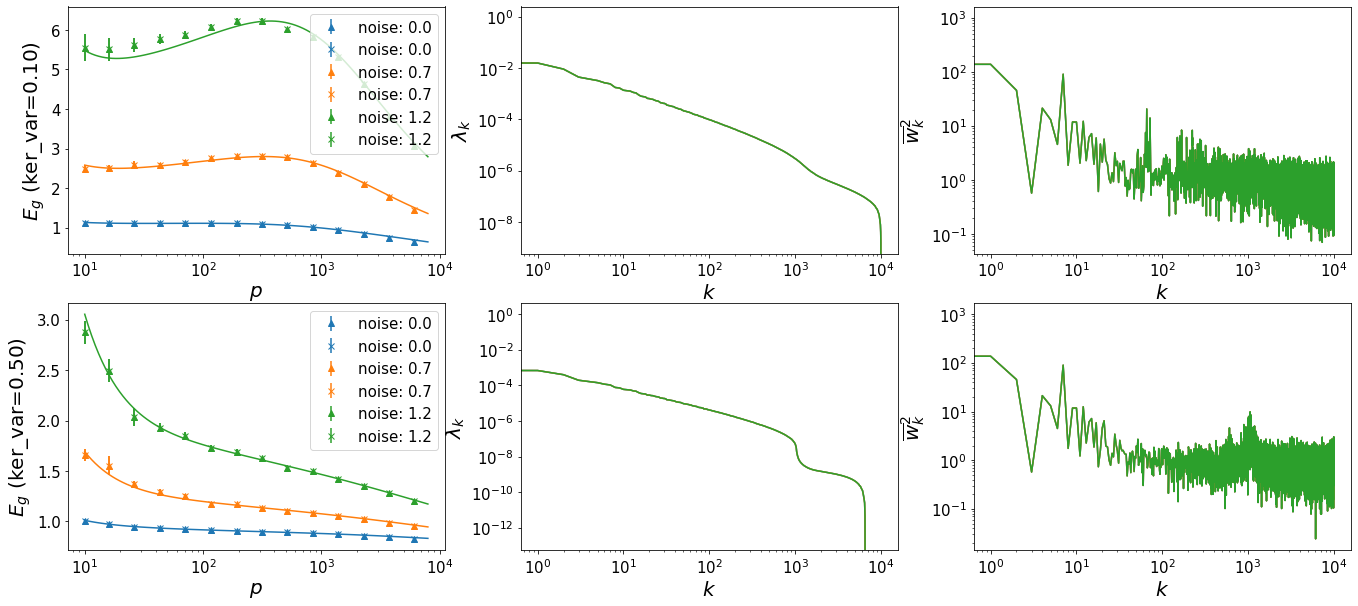

In [34]:
## Plotting the curves

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(len(ker_var), 3)
fig.set_size_inches(23,5*len(ker_var))

## Specify the regularization index for plotting
j = reg_idx = 0

for i, var in enumerate(ker_var):
  for k, noise in enumerate(noise_std):

    if k==3:
      break

    theory = all_errs[i,j,k]
    train_theory = train_errs[i,j,k]
    exp = errs_ker[i,j,k][:-1]
    exp_onehot = errs_onehot_ker[i,j,k][:-1]
    std = stds_ker[i,j,k][:-1]/np.sqrt(num_repeats)

    axs[i,0].plot(ptheory, theory, color = 'C%d' % (k))
    #axs[i,0].plot(ptheory, train_theory,'o', color = 'C%d' % (k))
    axs[i,0].errorbar(pvals[:-1], exp, std, fmt='^', color = 'C%d' % (k), label = 'noise: %0.1f' %(noise_std[k]))
    axs[i,0].errorbar(pvals[:-1], exp_onehot, std, fmt='x', color = 'C%d' % (k), label = 'noise: %0.1f' %(noise_std[k]))
    axs[i,0].set_xlabel(r'$p$', fontsize=20)
    axs[i,0].set_ylabel(r'$E_g$ (ker_var=%0.2f)' %var, fontsize=20)
    axs[i,0].set_xscale('log')
    #axs[i,0].set_yscale('log')
    axs[i,0].legend()

    axs[i,1].loglog(spectrum[i])
    axs[i,1].set_ylabel(r'$\lambda_k$', fontsize=20)
    axs[i,1].set_xlabel(r'$k$', fontsize=20)

    axs[i,2].loglog(weights[i])
    axs[i,2].set_xlabel(r'$k$', fontsize=20)
    axs[i,2].set_ylabel(r'$\overline{w}_k^2$', fontsize=20)

plt.show()